# Attitude and Heading Reference System (AHRS)

Kevin Walchko

7 July 2019

---

An **attitude and heading reference system** (AHRS) consists of sensors on three axes that provide attitude information for aircraft, including roll, pitch and yaw. These are sometimes referred to as MARG (Magnetic, Angular Rate, and Gravity) sensors and consist of either solid-state or microelectromechanical systems (MEMS) gyroscopes, accelerometers and magnetometers. They are designed to replace traditional mechanical gyroscopic flight instruments.

Steps:

1. Determine a magnetometer bias based off a data set where we tumbled the sensor around in 3D space.
2. Determine the accelerometer bias based off the sensor sitting still on a table for a period of time
3. Using the still data set, correct both the magnetometer and acceleration data for the determined biases
4. Run the compass program and see what it gets
    1. Since the sensor is sitting still on a table, the answer should be: roll=pitch=0 and heading=240 degs

## References

- [Wikipedia AHRS](https://en.wikipedia.org/wiki/Attitude_and_heading_reference_system)

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import the_collector
from the_collector import BagIt, Pickle, Data
from matplotlib import pyplot as plt

from ins_nav.ahrs import AHRS
from squaternion import quat2euler

In [3]:
def apply_calibration(data, bias):
    """
    Given the data and the bias, correct the data 
    """
    c_data = []
    for d in data:
        t = []
        for i in [0,1,2]:
            t.append(d[i]-bias[i])
        c_data.append(t)
            
    return c_data

In [4]:
def find_still_calibration(a, ref):
    # we expect to see [0,0,1] for acceleration, so we will find the 
    # average offset from
    # that value and use it as the bias ... this is far from the best
    # way to do this in the real world.
    xx = np.mean([x[0] for x in a])
    yy = np.mean([x[1] for x in a])
    zz = np.mean([x[2] for x in a])
    
    return (xx - ref[0], yy - ref[1], zz - ref[2],)

In [5]:
def find_mag_calibration(mag):
    """
    Go through the raw data and find the max/min for x, y, z
    """
    max_m = [-1000]*3
    min_m = [1000]*3
    for m in mag:
        for i in range(3):
            max_m[i] = m[i] if m[i] > max_m[i] else max_m[i]
            min_m[i] = m[i] if m[i] < min_m[i] else min_m[i]
    bias = [0]*3
    for i in range(3):
        bias[i] = (max_m[i] + min_m[i])/2
    return bias

In [6]:
# use the tumble data to get a good bias for the magnetometers.
# It turns out, that you want to understand the Earth's magnetic
# field in all orientations and determine a bias from that. We will
# calibrate the accelerometer differently
bag = BagIt(Pickle)
cal = bag.read('data-tumble.pickle.bag')
mag = [x.data for x in cal['mag']]
m_bias = find_mag_calibration(mag)

>>  pickle
>> Reading[pickle]: data-tumble.pickle.bag


In [8]:
# get the still data
still_cal = bag.read('data-still.pickle.bag')

# get and correct acceleration data
sa = [x.data for x in still_cal['accel']]
a_bias = find_still_calibration(sa, (0,0,1))
csa = apply_calibration(sa, a_bias)

# get and correct the magnetometer data, but notice we are
# using the bias that was detected from the tumble data set
sm = [x.data for x in still_cal['mag']]
csm = apply_calibration(sm, m_bias)

# get and correct the gyros, since the sensor is sitting
# still on a table, they should all be 0
sg = [x.data for x in still_cal['gyro']]
g_bias = find_still_calibration(sg, [0,0,0])
csg = apply_calibration(sg, g_bias)

>> Reading[pickle]: data-still.pickle.bag


In [43]:
ahrs = AHRS()

# beta determines how fast the signal jumps to the true answer.
# The lower the number, the smoother (slower) the response is
# to change. The higher the number, the more noise (jumpier)
# (and faster) the response is. 
# smaller beta: smoother, slower, laggier
# higher beta: rougher, noisier, faster
beta = 2.0

# data was collected around 200 Hz
dt = 1/200

save_r = []
save_p = []
save_y = []

t = list(1/200 * np.array(list(range(len(csg)))))

for a, m, g in zip(csa, csm, csg):
    q = ahrs.updateAGM(a,m,g,beta,dt)
    r,p,y = quat2euler(*q, degrees=True)
    save_r.append(r)
    save_p.append(p)
    save_y.append(y)

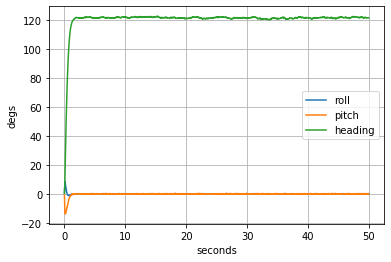

In [44]:
# The data was collected with the compass sitting flat on a
# table. Thus, roll = pitch = 0 and heading should be around
# the 240 degs (without accounting for declination angle).
plt.plot(t,save_r, label="roll")
plt.plot(t,save_p, label="pitch")
plt.plot(t,save_y, label="heading")
plt.grid(True)
plt.ylabel("degs")
plt.xlabel("seconds")
plt.legend();

# Conclusion - ERROR in above, should be ~240

We end up with what we want: roll=pitch=0 and heading=240 (really close) ... **success!** 

The acceration calibration was only done in the z-axis direction. For better performance, it should be done in x, y, and z axis directions (both positive and negative) and couple axis x-y, x-z, and y-z directions (basically tilt the sensor so gravity is on both axes at the same time).